In [59]:
# %%capture
# !pip install mlflow

In [60]:
import torch

## CHOOSE MODEL PARAMETERS #################################################

HIDDEN_DIM = 3*768
DATA_PATH = 'data/'
DEVICE='cuda' if torch.cuda.is_available() else 'cpu'
NAME_MODEL_NAME = 'cointegrated/rubert-tiny' # 'DeepPavlov/distilrubert-tiny-cased-conversational-v1'
DESCRIPTION_MODEL_NAME = 'cointegrated/rubert-tiny'

# BATCH_SIZE=90
# NUM_WORKERS=8
# NUM_DEBUG_SAMPLES=None
# EPOCHS=20

BATCH_SIZE=1
NUM_WORKERS=0
NUM_DEBUG_SAMPLES=4 # minimum 4 samples (2 per each of train/val) for stratified split
EPOCHS=1

EMB_SIZE=768
VALIDATION_SPLIT=.25
SHUFFLE_DATASET=True
RANDOM_SEED=42
LR=9e-5
MOMENTUM=0.9
WEIGHT_DECAY=1e-2
CONTRASTIVE_MARGIN=1.5
CONTRASTIVE_THRESHOLD=0.3
SHEDULER_PATIENCE=3 # in epochs
SMTH='1gpu'

In [61]:
## CHOOSE DATA #########################################################

# # These table files need 'image_name_first', 'image_name_second' constructed from sku to be usable in current pipeline
# TABLE_DATASET_FILE = 'tables_labeled/processed/labeled_1.3k_with-options.csv'
# TABLE_DATASET_FILE = 'tables_labeled/processed/labeled_56k_with-options.csv'
# IMG_DATASET_NAME = 'images_7k'
# STRATIFY_COLS = None

# TABLE_DATASET_FILE = 'tables_labeled/processed/labeled_5k_with-options.csv'
# IMG_DATASET_NAME = 'images_7k' 
# STRATIFY_COLS = None

# TABLE_DATASET_FILE = 'tables_WB_OZ_100/WB_OZ_100.csv'
# TABLE_DATASET_FILE = 'tables_WB_OZ_100/WB_OZ_100_conjugated.csv'
# TABLE_DATASET_FILE = 'tables_WB_OZ_100/WB_OZ_100_conjugated_shuffled_seed=42_fraction=1.csv'
# TABLE_DATASET_FILE = 'tables_WB_OZ_100/WB_OZ_100_conjugated_shuffled_seed=42_fraction=0.5.csv'
# IMG_DATASET_NAME = 'images_WB_OZ_100'
# STRATIFY_COLS = None

TABLE_DATASET_FILE = 'tables_OZ_geo_5500/processed/regex-pairwise-dataset_num-queries=20_num-pairs=6226_patterns-dict-hash=6dbf9b3ef9568e60cd959f87be7e3b26.csv'
IMG_DATASET_NAME = 'images_OZ_geo_5500'
STRATIFY_COLS = ['sku_first', 'label']

In [ ]:
## LOGGING PARAMS ######################################################################

# MLFLOW_URI = "http://176.56.185.96:5000"
MLFLOW_URI = ''

MLFLOW_EXPERIMENT = "siamese/1fold"

TELEGRAM_TOKEN = ''

In [49]:
# Imports
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import mlflow
from mlflow.models import infer_signature

from timm import create_model
import numpy as np
import pandas as pd
import os
import torch
from torch import nn
from torch import optim, Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
from torchinfo import summary
# import transformers
# from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer,\
#         get_linear_schedule_with_warmup
from transformers import AutoModel, AutoTokenizer

import cv2

from PIL import Image
from tqdm.auto import tqdm

# import json
# from itertools import product

# import datasets
# from datasets import Dataset, concatenate_datasets
# import argparse
import requests

# from io import BytesIO
# from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, f1_score
import matplotlib.pyplot as plt
from IPython import display
# import more_itertools

from sklearn.model_selection import train_test_split

In [50]:
def make_tg_report(text, token) -> None:
    method = 'sendMessage'
    chat_id = 324956476
    _ = requests.post(
            url='https://api.telegram.org/bot{0}/{1}'.format(token, method),
            data={'chat_id': chat_id, 'text': text} 
        ).json()

In [51]:
class RuCLIPtiny(nn.Module):
    def __init__(self):
        super().__init__()
        self.visual = create_model('convnext_tiny',
                                   pretrained=False, # TODO: берём претрейн
                                   num_classes=0,
                                   in_chans=3)  # out 768

        self.transformer = AutoModel.from_pretrained(NAME_MODEL_NAME)
        name_model_output_shape = self.transformer.config.hidden_size  # dynamically get hidden size
        self.final_ln = torch.nn.Linear(name_model_output_shape, 768)  # now uses the transformer hidden size
        self.logit_scale = torch.nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

    @property
    def dtype(self):
        return self.visual.stem[0].weight.dtype

    def encode_image(self, image):
        return self.visual(image.type(self.dtype))

    def encode_text(self, input_ids, attention_mask):
        x = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        x = x.last_hidden_state[:, 0, :]
        x = self.final_ln(x)
        return x

    def forward(self, image, input_ids, attention_mask):
        image_features = self.encode_image(image)
        text_features = self.encode_text(input_ids, attention_mask)

        # normalized features
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # cosine similarity as logits
        logit_scale = self.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logits_per_image.t()

        return logits_per_image, logits_per_text
    
def get_transform():
    return transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        _convert_image_to_rgb,
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]), ])

def _convert_image_to_rgb(image):
    return image.convert("RGB")

class Tokenizers:
    def __init__(self):
        self.name_tokenizer = AutoTokenizer.from_pretrained(NAME_MODEL_NAME)
        self.desc_tokenizer = AutoTokenizer.from_pretrained(DESCRIPTION_MODEL_NAME)

    def tokenize_name(self, texts, max_len=77):
        tokenized = self.name_tokenizer.batch_encode_plus(texts,
                                                     truncation=True,
                                                     add_special_tokens=True,
                                                     max_length=max_len,
                                                     padding='max_length',
                                                     return_attention_mask=True,
                                                     return_tensors='pt')
        return torch.stack([tokenized["input_ids"], tokenized["attention_mask"]])
    
    def tokenize_description(self, texts, max_len=77):
        tokenized = self.desc_tokenizer(texts,
                                        truncation=True,
                                        add_special_tokens=True,
                                        max_length=max_len,
                                        padding='max_length',
                                        return_attention_mask=True,
                                        return_tensors='pt')
        return torch.stack([tokenized["input_ids"], tokenized["attention_mask"]])

In [52]:
class SiameseRuCLIPDataset(torch.utils.data.Dataset):
    def __init__(self, df=None, labels=None, df_path=None, images_dir=DATA_PATH+'images/'):
        # loads data either from path using `df_path` or directly from `df` argument
        self.df = pd.read_csv(df_path) if df_path is not None else df
        self.labels = labels
        self.images_dir = images_dir
        self.tokenizers = Tokenizers()
        self.transform = get_transform()
        # 
        self.max_len = 77
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        name_tokens = self.tokenizers.tokenize_name([str(row.name_first), 
                                               str(row.name_second)], max_len=self.max_len)
        name_first = name_tokens[:, 0, :] # [input_ids, attention_mask]
        name_second = name_tokens[:, 1, :]
        desc_tokens = self.tokenizers.tokenize_description([str(row.description_first), 
                                               str(row.description_second)])
        desc_first = desc_tokens[:, 0, :] # [input_ids, attention_mask]
        desc_second = desc_tokens[:, 1, :]
        im_first = cv2.imread(os.path.join(self.images_dir, row.image_name_first))
        im_first = cv2.cvtColor(im_first, cv2.COLOR_BGR2RGB)
        im_first = Image.fromarray(im_first)
        im_first = self.transform(im_first)
        im_second = cv2.imread(os.path.join(self.images_dir, row.image_name_second))
        im_second = cv2.cvtColor(im_second, cv2.COLOR_BGR2RGB)
        im_second = Image.fromarray(im_second)
        im_second = self.transform(im_second)
        label = self.labels[idx]
        return im_first, name_first, desc_first, im_second, name_second, desc_second, label

    def __len__(self,):
        return len(self.df)
    
def average_pool(last_hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
        last_hidden = last_hidden_states.masked_fill(
            ~attention_mask[..., None].bool(), 0.0
        )
        return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

class SiameseRuCLIP(nn.Module):
    def __init__(self, preload_ruclip=True, device='cpu', hidden_dim=HIDDEN_DIM, models_dir=DATA_PATH + 'train_results/'):
        super().__init__()
        self.ruclip = RuCLIPtiny()
        if preload_ruclip:
            preload_model_name = 'cc12m_rubert_tiny_ep_1.pt' #'cc12m_ddp_4mill_ep_4.pt'
            std = torch.load(models_dir + preload_model_name, weights_only=True, map_location=device)
            self.ruclip.load_state_dict(std)
            self.ruclip = self.ruclip.to(device)
            self.ruclip.eval()
        self.description_transformer = AutoModel.from_pretrained(DESCRIPTION_MODEL_NAME)
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            # # nn.BatchNorm1d(hidden_dim),
            # nn.Dropout(0.3), 
            # nn.Linear(hidden_dim, hidden_dim // 2),
            # nn.ReLU(), 
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
        )
        
    def encode_description(self, desc):
        # desc is [input_ids, attention_mask]
        last_hidden_states = self.description_transformer(desc[:, 0, :], desc[:, 1, :]).last_hidden_state
        attention_mask = desc[:, 1, :]
        # TODO: нужно ли делать пулинг, посмотреть на результаты
        return average_pool(last_hidden_states, attention_mask)
    
    def forward(self, im1, name1, desc1, im2, name2, desc2):
        image_emb1 = self.ruclip.encode_image(im1)
        image_emb2 = self.ruclip.encode_image(im2)
        name_emb1 = self.ruclip.encode_text(name1[:, 0, :], name1[:, 1, :])
        name_emb2 = self.ruclip.encode_text(name2[:, 0, :], name2[:, 1, :])
        desc_emb1 = self.ruclip.encode_text(desc1[:, 0, :], desc1[:, 1, :])
        desc_emb2 = self.ruclip.encode_text(desc2[:, 0, :], desc2[:, 1, :])
        # desc_emb1 = self.encode_description(desc1) 
        # desc_emb2 = self.encode_description(desc2)
        first_emb = torch.cat([image_emb1, name_emb1, desc_emb1], dim=1)
        second_emb = torch.cat([image_emb2, name_emb2, desc_emb2], dim=1)
        out1 = self.head(first_emb)
        out2 = self.head(second_emb)
        return out1, out2
    

In [53]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        
    def __name__(self,):
        return 'ContrastiveLoss'

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        pos = (1-label) * torch.pow(euclidean_distance, 2)
        neg = label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        loss_contrastive = torch.mean( pos + neg )
        return loss_contrastive

In [54]:
def train(model, optimizer, criterion, 
          epochs_num, train_loader, valid_loader=None, 
          score=f1_score, device='cpu', print_epoch=False) -> None:
    model.train()
    model.to(device)
    counter = []
    loss_history = [] 
    it_number = 0
    best_valid_score = 0
    best_weights = None
    scheduler = ReduceLROnPlateau(optimizer, mode="max",
                                            factor=0.1, patience=SHEDULER_PATIENCE,
                                            threshold=0.0001,
                                            threshold_mode='rel', cooldown=0,
                                            min_lr=0, eps=1e-08)
    

    for epoch in range(epochs_num):
        print("Epoch：", epoch)
        for i, data in enumerate(tqdm(train_loader)):
            im1, name1, desc1, im2, name2, desc2, label = data 
            im1, name1, desc1, im2, name2, desc2, label = im1.to(device), name1.to(device), desc1.to(device), im2.to(device), name2.to(device), desc2.to(device), label.to(device)
            optimizer.zero_grad() 
            out1, out2 = model(im1, name1, desc1, im2, name2, desc2)
            loss = criterion(out1, out2, label)
            if MLFLOW_URI:
                mlflow.log_metric("train_loss", f"{loss:2f}", step=epoch)
            loss.backward()
            optimizer.step()
            if i % 1 == 0: # show changes of loss value after each 10 batches
                # it_number += 5
                counter.append(it_number)
                loss_history.append(loss.item())
        # test after each epoch
        if print_epoch:
            valid_score = validation(model, criterion, valid_loader, epoch, device)
            if MLFLOW_URI:
                mlflow.log_metric("valid_accuracy", f"{valid_score:2f}", step=epoch)
            plot_epoch(loss_history)
            print(f'Current train loss: {loss}')
            # print(f'Current {score.__name__}: {valid_score}')
            lr_to_log = optimizer.param_groups[0]['lr']
            if MLFLOW_URI:
                mlflow.log_metric("lr", f"{lr_to_log:2f}", step=epoch)
            scheduler.step(valid_score)
            if valid_score > best_valid_score:
                best_valid_score = valid_score
                best_weights = model.state_dict()
    return best_valid_score, best_weights

def validation(model, criterion, valid_loader, epoch, device='cpu') -> float:
    valid_loss = 0
    val_pos_accuracy = 0
    val_neg_accuracy = 0
    num_pos = 0
    num_neg = 0

    with torch.no_grad(): 
        for data in tqdm(valid_loader):
            im1, name1, desc1, im2, name2, desc2, label = data 
            im1, name1, desc1, im2, name2, desc2, label = (
                im1.to(device), name1.to(device), desc1.to(device),
                im2.to(device), name2.to(device), desc2.to(device), label.to(device)
            )
            out1, out2 = model(im1, name1, desc1, im2, name2, desc2) 
            loss = criterion(out1, out2, label)
            pos_acc, pos_sum, neg_acc, neg_sum = evaluate_pair(out1, out2, label, CONTRASTIVE_THRESHOLD)
            val_pos_accuracy += pos_acc
            val_neg_accuracy += neg_acc
            num_pos += pos_sum
            num_neg += neg_sum
            valid_loss += loss.item()

    val_pos_accuracy = val_pos_accuracy / num_pos if num_pos > 0 else 0.0
    val_neg_accuracy = val_neg_accuracy / num_neg if num_neg > 0 else 0.0
    valid_loss = valid_loss / len(valid_loader) if len(valid_loader) > 0 else 0.0

    report = (
        f"Epoch: {epoch}, Validation loss: {valid_loss:.3f}, "
        f"P Acc: {val_pos_accuracy:.3f}, N Acc: {val_neg_accuracy:.3f} " + SMTH + '\n'
    )
    print(report)
    make_tg_report(report, TELEGRAM_TOKEN)
    
    return (val_pos_accuracy + val_neg_accuracy) / 2

In [55]:
from pathlib import Path

def plot_epoch(loss_history, filename="data/runs_artifacts/epoch_loss.png") -> None:
    Path(filename).parent.mkdir(parents=True, exist_ok=True)
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
    plt.title("Training loss")
    plt.xlabel("Iteration number")
    plt.ylabel("Loss")
    plt.plot(loss_history, 'b')
    plt.tight_layout()
    plt.savefig(filename)  # Save the plot to a file
    plt.show()

In [56]:
def evaluate_pair(output1, output2, target, threshold):
    euclidean_distance = F.pairwise_distance(output1, output2)
    # меньше границы, там где будет True — конкуренты
    cond = euclidean_distance < threshold
    pos_sum = 0
    neg_sum = 0
    pos_acc = 0
    neg_acc = 0

    for i in range(len(cond)):
        # 1 значит не конкуренты
        if target[i]:
            neg_sum+=1
            # 0 в cond значит дальше друг от друга чем threshold
            if not cond[i]:
                neg_acc+=1
        elif not target[i]:
            pos_sum+=1
            if cond[i]:
                pos_acc+=1

    return pos_acc, pos_sum, neg_acc, neg_sum

def predict(out1, out2, threshold=CONTRASTIVE_THRESHOLD):
    # вернёт 1 если похожи
    return F.pairwise_distance(out1, out2) < threshold

In [43]:
images_dir = DATA_PATH + IMG_DATASET_NAME
labeled = pd.read_csv(DATA_PATH + TABLE_DATASET_FILE)

# 1) Sample (or shuffle) and reset index
if NUM_DEBUG_SAMPLES is not None:
    n = min(NUM_DEBUG_SAMPLES, len(labeled))
    labeled = labeled.sample(n=n, random_state=RANDOM_SEED)
else:
    labeled = labeled.sample(frac=1, random_state=RANDOM_SEED)

labeled = labeled.reset_index(drop=True)

# 2) Stratified (or plain) split on the sampled DataFrame
if STRATIFY_COLS:
    # build composite key
    stratify = labeled[STRATIFY_COLS].astype(str).agg('_'.join, axis=1)

    # find any strata of size 1 and force them into train
    vc = stratify.value_counts()
    single = vc[vc == 1].index
    mask_single = stratify.isin(single)

    # split only the “common” groups
    train_common, valid_index = train_test_split(
        labeled.index[~mask_single],
        test_size=VALIDATION_SPLIT,
        stratify=stratify[~mask_single],
        random_state=RANDOM_SEED,
        shuffle=True
    )
    # union back the singletons
    train_index = labeled.index[mask_single].union(train_common)
else:
    train_index, valid_index = train_test_split(
        labeled.index,
        test_size=VALIDATION_SPLIT,
        random_state=RANDOM_SEED,
        shuffle=True
    )

def _run():
    X, y = labeled.drop(columns='label'), labeled.label.values
    y = 1 - y 
    best_valid = 0

    print('Loading model and data...', end=' ')
    train_dataset = SiameseRuCLIPDataset(X.iloc[train_index], y[train_index], images_dir=images_dir)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
    valid_dataset = SiameseRuCLIPDataset(X.iloc[valid_index], y[valid_index], images_dir=images_dir)
    valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
    
    model = SiameseRuCLIP(device=DEVICE)
    criterion = ContrastiveLoss(margin=CONTRASTIVE_MARGIN)
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    print('done.')

    if MLFLOW_URI:
        # mlflow pipeline
        params = {
            "epochs": EPOCHS,
            "learning_rate": LR,
            "batch_size": BATCH_SIZE,
            'weight_decay': WEIGHT_DECAY, 
            'num_workers': NUM_WORKERS,
            "loss_function": criterion.__class__.__name__,
            'scheduler': ReduceLROnPlateau.__class__.__name__,
            'patience': SHEDULER_PATIENCE, 
            "optimizer": optimizer.__class__.__name__,
        }

        mlflow.log_params(params)
        with open("siam_summary.txt", "w") as f:
            f.write(str(summary(model)))
        mlflow.log_artifact("siam_summary.txt")
        ###########

    best_valid_score, best_weights = train(model, optimizer, criterion,
        EPOCHS, train_loader, valid_loader, 
        score=f1_score, print_epoch=True, device=DEVICE
    )

    if best_valid_score > best_valid:
        best_valid = best_valid_score
        torch.save(best_weights, f'siamese_contrastive_{SMTH}.pt')

    # save model w/ signature
    batch = next(iter(valid_loader))
    im1_ex, name1_ex, desc1_ex, im2_ex, name2_ex, desc2_ex, _ = [
        t.to(DEVICE).cpu().numpy() for t in batch
    ]
    out1_ex, out2_ex = model(
        torch.from_numpy(im1_ex).to(DEVICE),
        torch.from_numpy(name1_ex).to(DEVICE),
        torch.from_numpy(desc1_ex).to(DEVICE),
        torch.from_numpy(im2_ex).to(DEVICE),
        torch.from_numpy(name2_ex).to(DEVICE),
        torch.from_numpy(desc2_ex).to(DEVICE),
    )
    out1_ex = out1_ex.cpu().detach().numpy()
    out2_ex = out2_ex.cpu().detach().numpy()

    # Build dicts of NumPy arrays
    signature_input  = {
        "im1":  im1_ex,
        "name1":name1_ex,
        "desc1":desc1_ex,
        "im2":  im2_ex,
        "name2":name2_ex,
        "desc2":desc2_ex,
    }
    signature_output = {
        "out1": out1_ex,
        "out2": out2_ex,
    }

    # Infer signature
    signature = infer_signature(signature_input, signature_output)

    # Log only with signature (no input_example)
    if MLFLOW_URI:
        mlflow.pytorch.log_model(
            model,
            artifact_path="model",
            signature=signature
        )

    if TELEGRAM_TOKEN:
        make_tg_report(f'Лучший валид лосс: {best_valid:.3f}'+SMTH, TELEGRAM_TOKEN)

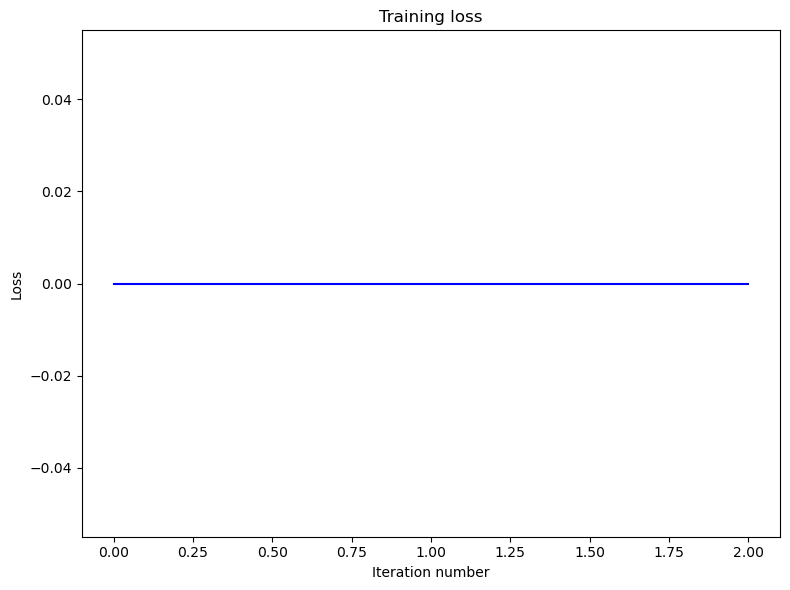

Current train loss: 0.0


In [44]:
if MLFLOW_URI:
    mlflow.set_tracking_uri(uri=MLFLOW_URI)
    mlflow.set_experiment(MLFLOW_EXPERIMENT)
    mlflow.enable_system_metrics_logging()

    with mlflow.start_run():
        _run()
else:
    _run()